In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim

# Data Loading
df = pd.read_csv("Data/merged_crime_vacant.csv")

# Group and aggregate
neighborhood_stats = df.groupby('Neighborhood').agg({
    'Vacant_Property_Count': ['mean', 'sum', 'count'],
    'Crime_Count': ['mean', 'sum']
}).reset_index()

# Flatten multi-index
neighborhood_stats.columns = ['_'.join(col).strip() for col in neighborhood_stats.columns.values]
neighborhood_stats.rename(columns={'Neighborhood_': 'Neighborhood'}, inplace=True)

# Create engineered features
neighborhood_stats['Vacant_Per_Crime'] = (
    neighborhood_stats['Vacant_Property_Count_sum'] / (neighborhood_stats['Crime_Count_sum'] + 1)
)

# Feature matrix (X) and target (y)
X = neighborhood_stats[[
    'Vacant_Property_Count_mean', 
    'Vacant_Property_Count_sum',
    'Vacant_Property_Count_count',
    'Crime_Count_sum',
    'Vacant_Per_Crime'
]].values

y = neighborhood_stats['Crime_Count_mean'].values.reshape(-1, 1)

# Split data
all_neighborhoods = neighborhood_stats['Neighborhood'].values
X_train, X_test, y_train, y_test, neighborhoods_train, neighborhoods_test = train_test_split(
    X, y, all_neighborhoods, test_size=0.2, random_state=42
)

# Normalize features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Updated Neural Network
class NeighborhoodCrimePredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Model, loss, optimizer
model = NeighborhoodCrimePredictor(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [2]:
# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_test_tensor.numpy())

rmse_nn = np.sqrt(mean_squared_error(y_true, y_pred))
r2_nn = r2_score(y_true, y_pred)

print("\n🔍 Neural Network Evaluation:")
print(f"RMSE: {rmse_nn:.2f}")
print(f"R^2: {r2_nn:.2f}")

# Baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)
y_pred_lr_scaled = lr.predict(X_test_scaled)
y_pred_lr = y_scaler.inverse_transform(y_pred_lr_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))
r2_lr = r2_score(y_true, y_pred_lr)

print("\n🧪 Linear Regression Baseline:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R^2: {r2_lr:.2f}")

Epoch [0/500], Loss: 1.0352
Epoch [50/500], Loss: 0.2866
Epoch [100/500], Loss: 0.0413
Epoch [150/500], Loss: 0.0380
Epoch [200/500], Loss: 0.0258
Epoch [250/500], Loss: 0.0602
Epoch [300/500], Loss: 0.0248
Epoch [350/500], Loss: 0.0272
Epoch [400/500], Loss: 0.0171
Epoch [450/500], Loss: 0.0436

🔍 Neural Network Evaluation:
RMSE: 2.55
R^2: 1.00

🧪 Linear Regression Baseline:
RMSE: 0.00
R^2: 1.00


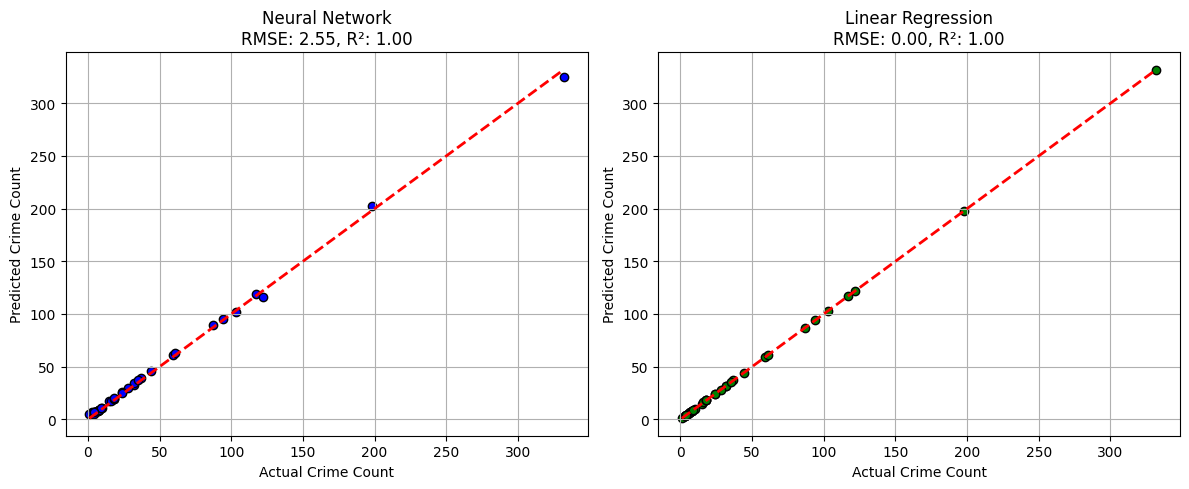

In [3]:
import matplotlib.pyplot as plt

# Plot Neural Network predictions
plt.figure(figsize=(12, 5))

# 🔵 Neural Network Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred, color='blue', edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
plt.xlabel("Actual Crime Count")
plt.ylabel("Predicted Crime Count")
plt.title(f"Neural Network\nRMSE: {rmse_nn:.2f}, R²: {r2_nn:.2f}")
plt.grid(True)

# 🟢 Linear Regression Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_lr, color='green', edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
plt.xlabel("Actual Crime Count")
plt.ylabel("Predicted Crime Count")
plt.title(f"Linear Regression\nRMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")
plt.grid(True)

plt.tight_layout()
plt.show()
